In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import tensorflow as tf
import visualkeras
import zipfile

import wandb
wandb.login()

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm
from wandb.keras import WandbMetricsLogger, WandbEvalCallback, WandbModelCheckpoint


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # configure utilization of GPUs
    try:
        for gpu in gpus:
            # memory growth setting
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=256)]
            )
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        module_logger.error(e)


# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

wandb: Currently logged in as: stevo (hysped). Use `wandb login --relogin` to force relogin


In [2]:
def mkdir(path):
    if not os.path.isdir(path):
        if not os.path.exists(path):
            os.mkdir(path)
            
def predict_model(m, X, Y, label_encoder):
    Y_pred = m.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_pred = label_encoder.inverse_transform(Y_pred)
    Y_pred = pd.DataFrame(Y_pred, columns=['Y_pred'])
    return Y_pred

def plot_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

## Configuration

In [3]:
cfg = dict(
    data_dir = os.path.join('..', 'data', 'Sverepec_spolu_preprocessed_top4'),
    models_dir = os.path.join('..', 'models'),
    class_column = 'DRUH_DR',
    model_name = 'conv1D_top4',
    num_conv1D_layers = 3,
)
cfg['project_name'] = 'hysped-%s' % cfg['model_name']

mkdir(cfg['models_dir'])
display(JSON(cfg, expanded=True))

<IPython.core.display.JSON object>

## Load data

In [4]:
X_train = pd.read_parquet(os.path.join(cfg['data_dir'], 'X_train.parquet'))
Y_train = pd.read_parquet(os.path.join(cfg['data_dir'], 'Y_train.parquet'))
X_val = pd.read_parquet(os.path.join(cfg['data_dir'], 'X_val.parquet'))
Y_val = pd.read_parquet(os.path.join(cfg['data_dir'], 'Y_val.parquet'))

label_encoder = LabelEncoder()
encoder_filename = os.path.join(cfg['data_dir'], 'encoder-%s.npy' % cfg['class_column'])
label_encoder.classes_ = np.load(encoder_filename, allow_pickle=True)

num_classes = len(label_encoder.classes_)

X_train = X_train.values
Y_train = to_categorical(
    label_encoder.transform(Y_train[cfg['class_column']]),
    num_classes=num_classes
)

X_val = X_val.values
Y_val = to_categorical(
    label_encoder.transform(Y_val[cfg['class_column']]),
    num_classes=num_classes
)

## Model architecture

In [5]:
def make_model(
    input_shape: tuple,
    filters: [int],
    kernel_sizes: [int],
    num_classes: int,
    padding: str,
    **kwargs
):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Input(
            shape=input_shape
        )
    )
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    
    for f,k in zip(filters, kernel_sizes):
        model.add(
            tf.keras.layers.Conv1D(
                filters=f,
                kernel_size=k,
                activation=tf.nn.relu,
                padding=padding
            )
        )
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes * 2))
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Softmax())
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

## Train model

In [30]:
config = dict(
    input_shape=(X_train.shape[1], 1),   
    filters=[512,256,128,64],
    kernel_sizes=[9,7,5,3],
    num_classes=Y_train.shape[1],
    padding='causal'
)

run = wandb.init(
    project=cfg['project_name'],
    config=config
)
logger.info('run.id: %s, run.name: %s' % (run.id, run.name))

model = make_model(**run.config)
model.summary()

model_dir = os.path.join(cfg['models_dir'], cfg['model_name'])
mkdir(model_dir)
logger.info('model_dir: %s' % model_dir)
model_file = os.path.join(model_dir, 'run_%s_model.h5' % (run.id))
logger.info('model_file: %s' % model_file)

wandbModelCheckpoint = WandbModelCheckpoint(
    model_file,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True
)

callbacks = [
    WandbMetricsLogger(),
    wandbModelCheckpoint,
]

history = model.fit(
    x=X_train,
    y=Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    shuffle=True,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

run.finish()
wandb.finish()

2023-04-07 13:32:32,626 | hysped | INFO : run.id: gtsmpet1, run.name: balmy-music-78
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 186, 1)           4         
 hNormalization)                                                 
                                                                 
 conv1d_12 (Conv1D)          (None, 186, 512)          5120      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 93, 512)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 93, 256)           917760    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 46, 256)          0         
 1D)                               

epoch/categorical_accuracy,▁▃▄▄▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█████▇██████████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▄▇▆▇▇▇█▇▇▇██▇█▇█████▆██████████▇█
epoch/val_loss,▅▆█▇▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,0.84666
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.41076
epoch/val_categorical_accuracy,0.89089


## Confusion matrix

136/136 [==============================] - 1s 5ms/step


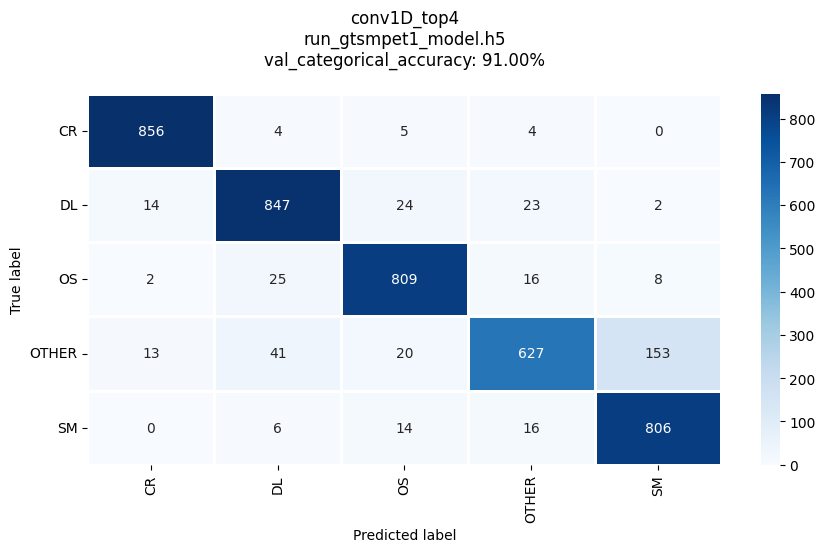

In [31]:
# load the best model
m = tf.keras.models.load_model(wandbModelCheckpoint.filepath)

Y_pred = predict_model(m, X_val, Y_val, label_encoder=label_encoder)
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(Y_val, axis=1)), Y_pred)

fig, ax = plt.subplots(figsize=(9,5))
plot_cm(ax, cm, labels=label_encoder.classes_)
plt.title('%s\n%s\n%s: %.2f%%\n' % (cfg['model_name'], os.path.basename(model_file), wandbModelCheckpoint.monitor, wandbModelCheckpoint.best * 100.0))
plt.show()

## Hyperparameter tuning

In [32]:
# Define the search space
sweep_configuration = {
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_categorical_accuracy'
    },
    'parameters': {
        'input_shape': {
            'values': [(X_train.shape[1], 1)]
        },
        'num_classes': {
            'values': [num_classes]
        },
        'kernel_sizes': {
            'values': [
                [kernel_size for conv1d_layer in range(cfg['num_conv1D_layers'])] for kernel_size in [3,5,7,9,11,13,15]
            ]
        },
        'filters': {
            'values': [
                [2**(conv1d_layer+i) for conv1d_layer in range(cfg['num_conv1D_layers'],0,-1)] for i in range(8)
            ]
        },
        'batch_size': {
            'values': [
                128
            ]
        },
        'padding': {
            'values': [
                'causal'
            ]
        }
    }
}

display(JSON(sweep_configuration, expanded=True))

<IPython.core.display.JSON object>

In [52]:
def main():
    run = wandb.init(project=cfg['project_name'])
    model = make_model(**wandb.config)
    
    model_dir = os.path.join(cfg['models_dir'], cfg['model_name'])
    mkdir(model_dir)
    logger.info('model_dir: %s' % model_dir)
    model_file = os.path.join(model_dir, 'run_%s_model.h5' % (run.id))
    logger.info('model_file: %s' % model_file)
    
    wandbModelCheckpoint = WandbModelCheckpoint(
        model_file,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True
    )

    callbacks = [
        WandbMetricsLogger(),
        wandbModelCheckpoint,
    ]

    history = model.fit(
        x=X_train,
        y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=50,
        shuffle=True,
        batch_size=wandb.config.batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    wandb.log({
        wandbModelCheckpoint.monitor: wandbModelCheckpoint.best
    })
    run.finish()
    # wandb.log(pd.DataFrame(history.history)[-1:].reset_index(drop=True).to_dict(orient='records')[0])

# Start the sweep
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project=cfg['project_name']
)
wandb.agent(sweep_id, function=main, count=50)
wandb.finish()

Create sweep with ID: z1gj71w2
Sweep URL: https://wandb.ai/hysped/hysped-conv1D_top4/sweeps/z1gj71w2


wandb: Agent Starting Run: ic3x6ked with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:21:25,072 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:21:25,073 | hysped | INFO : model_file: ../models/conv1D_top4/run_ic3x6ked_model.h5
Epoch 1/50
80/80 [==============================] - 5s 32ms/step - loss: 1.3464 - categorical_accuracy: 0.3893 - val_loss: 3.5448 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1972 - categorical_accuracy: 0.4921 - val_loss: 5.1735 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0207 - categorical_accuracy: 0.5811 - val_loss: 4.6646 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9324 - categorical_accuracy: 0.6237 - val_loss: 6.0264 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 0.8778 - categorical_accuracy: 0.6538 - val_loss: 5.3316 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇██▇██▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▄▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▄▇▇▇▇▇▇▇▇▇██▇▇██▇█▇███▇██▇▇█▇▇████
epoch/val_loss,▅▇▆█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.76214
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.63778


wandb: Agent Starting Run: gjjjn2dm with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:22:50,406 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:22:50,407 | hysped | INFO : model_file: ../models/conv1D_top4/run_gjjjn2dm_model.h5
Epoch 1/50
80/80 [==============================] - 5s 27ms/step - loss: 1.3244 - categorical_accuracy: 0.4191 - val_loss: 1.6239 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0326 - categorical_accuracy: 0.5580 - val_loss: 1.6163 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8845 - categorical_accuracy: 0.6261 - val_loss: 1.5995 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.8167 - categorical_accuracy: 0.6620 - val_loss: 1.7118 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 0.7919 - categorical_accuracy: 0.6757 - val_loss: 2.3706 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇███████▇███████▇████▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▄▆▇▇▇▅▇▇██▇█▇█████▇▇█████▇▇███████▇
epoch/val_loss,██▇█▇▅▃▃▂▂▃▃▂▂▁▂▁▂▁▁▁▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.87781
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.34139


wandb: Agent Starting Run: ijedfaki with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:24:14,158 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:24:14,159 | hysped | INFO : model_file: ../models/conv1D_top4/run_ijedfaki_model.h5
Epoch 1/50
80/80 [==============================] - 5s 32ms/step - loss: 1.3118 - categorical_accuracy: 0.4226 - val_loss: 2.4046 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0907 - categorical_accuracy: 0.5379 - val_loss: 3.5875 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9282 - categorical_accuracy: 0.6222 - val_loss: 4.1987 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8550 - categorical_accuracy: 0.6565 - val_loss: 5.7622 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8040 - categorical_accuracy: 0.6827 - val_loss: 4.0170 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇████▇█▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▂▂▂▁▂▂▂▁▁▁▁▂▁▂
epoch/val_categorical_accuracy,▁▁▁▁▁▃▆▇▇▇▇██▇▇█▇████▇███████▇██████▇███
epoch/val_loss,▄▅▆█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.80049
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.53757


wandb: Agent Starting Run: ei88cage with config:
wandb: 	batch_size: 128
wandb: 	filters: [64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:25:42,626 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:25:42,627 | hysped | INFO : model_file: ../models/conv1D_top4/run_ei88cage_model.h5
Epoch 1/50
80/80 [==============================] - 4s 22ms/step - loss: 1.4004 - categorical_accuracy: 0.3823 - val_loss: 1.7144 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.1869 - categorical_accuracy: 0.4997 - val_loss: 2.0533 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0582 - categorical_accuracy: 0.5568 - val_loss: 1.9048 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9265 - categorical_accuracy: 0.6264 - val_loss: 1.8187 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8908 - categorical_accuracy: 0.6293 - val_loss: 1.6712 - val_categorical_accuracy: 0.2962
Ep

epoch/categorical_accuracy,▁▃▄▅▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▆▆▇▇▇███████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▄▃▃▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▂▄▄▆▆▇▇▇▇▇█████▇▇▇█████████▇███████
epoch/val_loss,▇█▇▇▆▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.86653
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.36799


wandb: Agent Starting Run: uq7m7uva with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:27:06,417 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:27:06,418 | hysped | INFO : model_file: ../models/conv1D_top4/run_uq7m7uva_model.h5
Epoch 1/50
80/80 [==============================] - 8s 67ms/step - loss: 1.2138 - categorical_accuracy: 0.4780 - val_loss: 3.1839 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 4s 51ms/step - loss: 0.9735 - categorical_accuracy: 0.5984 - val_loss: 4.3630 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 4s 52ms/step - loss: 0.8485 - categorical_accuracy: 0.6663 - val_loss: 6.0674 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 4s 52ms/step - loss: 0.8450 - categorical_accuracy: 0.6709 - val_loss: 10.4430 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 4s 52ms/step - loss: 0.7448 - categorical_accuracy: 0.7172 - val_loss: 7.5590 - val_categorical_accuracy: 0.1970
E

epoch/categorical_accuracy,▁▃▅▅▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇██▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▃▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▂▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▂▅▇▇▇▇▇▇▇▇▇█▇█▇▇█▇▇█▇█▇██▇█████████
epoch/val_loss,▃▄▅█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.81878
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.49741


wandb: Agent Starting Run: pajxg0il with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:30:49,329 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:30:49,330 | hysped | INFO : model_file: ../models/conv1D_top4/run_pajxg0il_model.h5
Epoch 1/50
80/80 [==============================] - 4s 21ms/step - loss: 1.4736 - categorical_accuracy: 0.3406 - val_loss: 1.5936 - val_categorical_accuracy: 0.2081
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3038 - categorical_accuracy: 0.4409 - val_loss: 2.3351 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1793 - categorical_accuracy: 0.5057 - val_loss: 3.0883 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0839 - categorical_accuracy: 0.5536 - val_loss: 3.2069 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0325 - categorical_accuracy: 0.5720 - val_loss: 2.8763 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▆▇▆▇▇▇▇▇▇▇▇▆▇█▇▇▇▇██▇▇██▇████████
epoch/val_loss,▄▆██▇▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.73297
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.70633


wandb: Agent Starting Run: s3yesut0 with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:32:12,816 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:32:12,818 | hysped | INFO : model_file: ../models/conv1D_top4/run_s3yesut0_model.h5
Epoch 1/50
80/80 [==============================] - 4s 27ms/step - loss: 1.3703 - categorical_accuracy: 0.3804 - val_loss: 1.6257 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1478 - categorical_accuracy: 0.5212 - val_loss: 2.5469 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 0.9692 - categorical_accuracy: 0.6023 - val_loss: 3.5707 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 0.9168 - categorical_accuracy: 0.6229 - val_loss: 3.9918 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 16ms/step - loss: 0.8438 - categorical_accuracy: 0.6536 - val_loss: 3.5620 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▂
epoch/val_categorical_accuracy,▁▁▁▁▁▃▅▆▇▇▇▇▇▇▇▇▇▇██████▇██▇██▇████▇████
epoch/val_loss,▄▅▇█▇▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.83826
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.44526


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v7b9w0ln with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:33:45,830 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:33:45,831 | hysped | INFO : model_file: ../models/conv1D_top4/run_v7b9w0ln_model.h5
Epoch 1/50
80/80 [==============================] - 5s 38ms/step - loss: 1.1889 - categorical_accuracy: 0.4810 - val_loss: 1.5986 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 2s 29ms/step - loss: 0.9167 - categorical_accuracy: 0.6136 - val_loss: 1.6818 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 2s 29ms/step - loss: 0.7746 - categorical_accuracy: 0.6892 - val_loss: 1.9959 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 2s 29ms/step - loss: 0.7484 - categorical_accuracy: 0.7010 - val_loss: 2.4381 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 2s 28ms/step - loss: 0.6900 - categorical_accuracy: 0.7180 - val_loss: 2.5134 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇█████████████████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▁▁▂▄▆▆▇▅▇▇████▇███▇███████▇█▇█████████
epoch/val_loss,▅▆▇█▅▄▂▂▂▅▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.86812
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.36276


wandb: Agent Starting Run: xl5wp6pi with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:35:56,291 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:35:56,292 | hysped | INFO : model_file: ../models/conv1D_top4/run_xl5wp6pi_model.h5
Epoch 1/50
80/80 [==============================] - 10s 91ms/step - loss: 1.2812 - categorical_accuracy: 0.4494 - val_loss: 1.6189 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 6s 73ms/step - loss: 0.9641 - categorical_accuracy: 0.6063 - val_loss: 2.0469 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 6s 73ms/step - loss: 0.7694 - categorical_accuracy: 0.6903 - val_loss: 4.6581 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 6s 73ms/step - loss: 0.6929 - categorical_accuracy: 0.7282 - val_loss: 6.6921 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 6s 74ms/step - loss: 0.6966 - categorical_accuracy: 0.7265 - val_loss: 5.3147 - val_categorical_accuracy: 0.1970
E

epoch/categorical_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇█▇▇█▇▇█████████▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▄▅▆█▇▇███▇██▇█████▇▇█████▇█████████
epoch/val_loss,▃▃▆█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.90104
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.26711


wandb: Agent Starting Run: bswpiqxd with config:
wandb: 	batch_size: 128
wandb: 	filters: [16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:41:08,188 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:41:08,190 | hysped | INFO : model_file: ../models/conv1D_top4/run_bswpiqxd_model.h5
Epoch 1/50
80/80 [==============================] - 4s 20ms/step - loss: 1.4448 - categorical_accuracy: 0.3681 - val_loss: 1.5933 - val_categorical_accuracy: 0.2710
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.2627 - categorical_accuracy: 0.4636 - val_loss: 1.5887 - val_categorical_accuracy: 0.2780
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1962 - categorical_accuracy: 0.4938 - val_loss: 1.5964 - val_categorical_accuracy: 0.3040
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1174 - categorical_accuracy: 0.5321 - val_loss: 1.6106 - val_categorical_accuracy: 0.2826
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0581 - categorical_accuracy: 0.5621 - val_loss: 1.4404 - val_categorical_accuracy: 0.3283
Ep

epoch/categorical_accuracy,▁▃▃▄▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇██▇██████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▂
epoch/val_categorical_accuracy,▁▁▁▁▃▃▃▅▅▇▇▆▆▆▇▇▇▇▇▇▇▇▇▆▇▇█▇▇█████▇▇▇██▇
epoch/val_loss,████▆▆▆▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▂
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.71181
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.7468


wandb: Agent Starting Run: pxrou947 with config:
wandb: 	batch_size: 128
wandb: 	filters: [8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:42:30,899 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:42:30,900 | hysped | INFO : model_file: ../models/conv1D_top4/run_pxrou947_model.h5
Epoch 1/50
80/80 [==============================] - 3s 19ms/step - loss: 1.5533 - categorical_accuracy: 0.3080 - val_loss: 1.6192 - val_categorical_accuracy: 0.2886
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.4179 - categorical_accuracy: 0.3913 - val_loss: 1.6542 - val_categorical_accuracy: 0.2597
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3271 - categorical_accuracy: 0.4373 - val_loss: 1.6981 - val_categorical_accuracy: 0.2537
Epoch 4/50
80/80 [==============================] - 1s 16ms/step - loss: 1.2757 - categorical_accuracy: 0.4612 - val_loss: 1.6752 - val_categorical_accuracy: 0.2653
Epoch 5/50
80/80 [==============================] - 1s 16ms/step - loss: 1.2252 - categorical_accuracy: 0.4932 - val_loss: 1.6156 - val_categorical_accuracy: 0.2925
Ep

epoch/categorical_accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇█▇▇▇█████▇█████▆
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▁▁▂▃▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇█▇████▇▇▇
epoch/val_loss,▇███▆▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▂▂
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.55462
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,1.05733


wandb: Agent Starting Run: cxtncsu1 with config:
wandb: 	batch_size: 128
wandb: 	filters: [16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:43:54,570 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:43:54,571 | hysped | INFO : model_file: ../models/conv1D_top4/run_cxtncsu1_model.h5
Epoch 1/50
80/80 [==============================] - 3s 20ms/step - loss: 1.5555 - categorical_accuracy: 0.2883 - val_loss: 1.6052 - val_categorical_accuracy: 0.1984
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.4290 - categorical_accuracy: 0.3608 - val_loss: 1.6358 - val_categorical_accuracy: 0.2604
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3392 - categorical_accuracy: 0.4172 - val_loss: 2.3101 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2717 - categorical_accuracy: 0.4538 - val_loss: 3.7816 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 16ms/step - loss: 1.2296 - categorical_accuracy: 0.4786 - val_loss: 4.1446 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▂▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▁▁▂▂▅▆▇▇▇▇▇▇▇█▇▇██████████████████████
epoch/val_loss,▃▃▅█▆▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.70479
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.7646


wandb: Agent Starting Run: c7b2pahh with config:
wandb: 	batch_size: 128
wandb: 	filters: [8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:45:17,386 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:45:17,388 | hysped | INFO : model_file: ../models/conv1D_top4/run_c7b2pahh_model.h5
Epoch 1/50
80/80 [==============================] - 3s 18ms/step - loss: 1.5958 - categorical_accuracy: 0.2355 - val_loss: 1.6110 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.4912 - categorical_accuracy: 0.3348 - val_loss: 1.7601 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3654 - categorical_accuracy: 0.3836 - val_loss: 1.9617 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3203 - categorical_accuracy: 0.4039 - val_loss: 1.7601 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2872 - categorical_accuracy: 0.4281 - val_loss: 1.5899 - val_categorical_accuracy: 0.2321
Ep

epoch/categorical_accuracy,▁▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇██████████████▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▃▄▅▅▇▇▇▇█▇██▇███████▇███████████████
epoch/val_loss,▆▇█▇▅▄▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.6782
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.80846


wandb: Agent Starting Run: h7z5rb0e with config:
wandb: 	batch_size: 128
wandb: 	filters: [8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:46:36,053 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:46:36,054 | hysped | INFO : model_file: ../models/conv1D_top4/run_h7z5rb0e_model.h5
Epoch 1/50
80/80 [==============================] - 3s 19ms/step - loss: 1.5820 - categorical_accuracy: 0.2478 - val_loss: 1.6167 - val_categorical_accuracy: 0.1942
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.4730 - categorical_accuracy: 0.3501 - val_loss: 1.6980 - val_categorical_accuracy: 0.1942
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3580 - categorical_accuracy: 0.4015 - val_loss: 1.6535 - val_categorical_accuracy: 0.2030
Epoch 4/50
80/80 [==============================] - 1s 16ms/step - loss: 1.2976 - categorical_accuracy: 0.4436 - val_loss: 1.5194 - val_categorical_accuracy: 0.2787
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2556 - categorical_accuracy: 0.4637 - val_loss: 1.3811 - val_categorical_accuracy: 0.3963
Ep

epoch/categorical_accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████▇▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁
epoch/val_categorical_accuracy,▁▁▁▂▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇████▇█▆▇▇██
epoch/val_loss,▇██▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▂▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.6697
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.84853


wandb: Agent Starting Run: 23sci9a0 with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:47:58,802 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:47:58,803 | hysped | INFO : model_file: ../models/conv1D_top4/run_23sci9a0_model.h5
Epoch 1/50
80/80 [==============================] - 6s 36ms/step - loss: 1.3190 - categorical_accuracy: 0.4165 - val_loss: 1.6995 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 2s 30ms/step - loss: 0.9955 - categorical_accuracy: 0.5921 - val_loss: 2.1252 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 2s 29ms/step - loss: 0.8092 - categorical_accuracy: 0.6640 - val_loss: 3.1906 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 2s 30ms/step - loss: 0.7462 - categorical_accuracy: 0.7026 - val_loss: 2.5006 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 2s 30ms/step - loss: 0.6867 - categorical_accuracy: 0.7345 - val_loss: 3.2424 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▄▅▅▆▆▆▆▇▆▇▇▇▆▇▇▇▇▇▇█▇███▇▇█▇▇█▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▄▆▇▇▇▇▇▆▇███▇▇▇██████████▆█████████
epoch/val_loss,▄▅█▆▅▃▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.89165
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.30141


wandb: Agent Starting Run: specqh9q with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:50:14,517 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:50:14,518 | hysped | INFO : model_file: ../models/conv1D_top4/run_specqh9q_model.h5
Epoch 1/50
80/80 [==============================] - 6s 44ms/step - loss: 1.2534 - categorical_accuracy: 0.4489 - val_loss: 1.6150 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 3s 34ms/step - loss: 0.9467 - categorical_accuracy: 0.6093 - val_loss: 1.6045 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 3s 33ms/step - loss: 0.8348 - categorical_accuracy: 0.6577 - val_loss: 1.7917 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 3s 34ms/step - loss: 0.7597 - categorical_accuracy: 0.6833 - val_loss: 2.0701 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 3s 34ms/step - loss: 0.9269 - categorical_accuracy: 0.6211 - val_loss: 4.2299 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇██▇▇██▇▇██▇█████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▄▅▇▇▇▇▇▇▇█▇█▇▇██▇▆██████▆██████████
epoch/val_loss,▅▅▆▇█▄▃▂▂▂▂▂▁▂▁▂▁▁▂▁▁▂▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.91033
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.24449


wandb: Agent Starting Run: rnhzrs7e with config:
wandb: 	batch_size: 128
wandb: 	filters: [16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:52:45,171 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:52:45,172 | hysped | INFO : model_file: ../models/conv1D_top4/run_rnhzrs7e_model.h5
Epoch 1/50
80/80 [==============================] - 4s 20ms/step - loss: 1.5399 - categorical_accuracy: 0.3103 - val_loss: 1.6087 - val_categorical_accuracy: 0.1942
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3701 - categorical_accuracy: 0.4140 - val_loss: 1.6128 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2321 - categorical_accuracy: 0.4839 - val_loss: 1.6362 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1449 - categorical_accuracy: 0.5276 - val_loss: 1.5636 - val_categorical_accuracy: 0.2328
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0529 - categorical_accuracy: 0.5710 - val_loss: 1.4291 - val_categorical_accuracy: 0.2918
Ep

epoch/categorical_accuracy,▁▂▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇████▇▇██▇▇██▇█
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▂▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇██████████████▇▇██▇██
epoch/val_loss,████▆▅▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▃▁▁▂▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.80623
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.53832


wandb: Agent Starting Run: cpj5b53f with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:54:07,864 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:54:07,865 | hysped | INFO : model_file: ../models/conv1D_top4/run_cpj5b53f_model.h5
Epoch 1/50
80/80 [==============================] - 4s 21ms/step - loss: 1.4784 - categorical_accuracy: 0.3373 - val_loss: 1.5925 - val_categorical_accuracy: 0.2738
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2807 - categorical_accuracy: 0.4510 - val_loss: 2.0413 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 16ms/step - loss: 1.1188 - categorical_accuracy: 0.5320 - val_loss: 2.2866 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9940 - categorical_accuracy: 0.5817 - val_loss: 2.6121 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9475 - categorical_accuracy: 0.6056 - val_loss: 2.9165 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇██▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▂▁▁▁▂▃▅▆▇▇▇▇▇▇▇▇▇█▇█▇███████▇██▇████████
epoch/val_loss,▅▆▇█▆▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.83055
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.47603


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7p4c38v6 with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:55:36,600 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:55:36,602 | hysped | INFO : model_file: ../models/conv1D_top4/run_7p4c38v6_model.h5
Epoch 1/50
80/80 [==============================] - 5s 33ms/step - loss: 1.3242 - categorical_accuracy: 0.4226 - val_loss: 2.0366 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 18ms/step - loss: 1.0729 - categorical_accuracy: 0.5452 - val_loss: 2.0935 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 0.9468 - categorical_accuracy: 0.6146 - val_loss: 3.2997 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8369 - categorical_accuracy: 0.6515 - val_loss: 2.8348 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 0.7775 - categorical_accuracy: 0.6922 - val_loss: 3.7477 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▇▇▇▆▇▇▇▇▆▇▆▇▇▇▇█████▇▇███▇███▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▂▃▃▂▂▂▂▄▂▃▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▆▇▇▆▇██▇▇▇▆▇████████▆███████▇████
epoch/val_loss,▅▅█▇▅▃▃▂▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.84014
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.43947


wandb: Agent Starting Run: hz3u739t with config:
wandb: 	batch_size: 128
wandb: 	filters: [8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:57:06,798 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:57:06,799 | hysped | INFO : model_file: ../models/conv1D_top4/run_hz3u739t_model.h5
Epoch 1/50
80/80 [==============================] - 3s 18ms/step - loss: 1.5975 - categorical_accuracy: 0.2250 - val_loss: 1.6121 - val_categorical_accuracy: 0.1942
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.5032 - categorical_accuracy: 0.3480 - val_loss: 1.6616 - val_categorical_accuracy: 0.1942
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3755 - categorical_accuracy: 0.4055 - val_loss: 1.8292 - val_categorical_accuracy: 0.1942
Epoch 4/50
80/80 [==============================] - 1s 16ms/step - loss: 1.2849 - categorical_accuracy: 0.4478 - val_loss: 1.8089 - val_categorical_accuracy: 0.1942
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2267 - categorical_accuracy: 0.4812 - val_loss: 1.6743 - val_categorical_accuracy: 0.2344
Ep

epoch/categorical_accuracy,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▅▇▇▇▇▇▇█████▇██▇█▇███████████▇███
epoch/val_loss,▇▇██▇▅▄▄▃▃▃▂▂▂▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.6609
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.83625


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5z25dk73 with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:58:33,680 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:58:33,681 | hysped | INFO : model_file: ../models/conv1D_top4/run_5z25dk73_model.h5
Epoch 1/50
80/80 [==============================] - 4s 27ms/step - loss: 1.3120 - categorical_accuracy: 0.4192 - val_loss: 1.6296 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0462 - categorical_accuracy: 0.5557 - val_loss: 1.6939 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9295 - categorical_accuracy: 0.6029 - val_loss: 1.6550 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.8534 - categorical_accuracy: 0.6431 - val_loss: 1.6132 - val_categorical_accuracy: 0.1977
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 0.7656 - categorical_accuracy: 0.6854 - val_loss: 1.5851 - val_categorical_accuracy: 0.2448
Ep

epoch/categorical_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇█▇▇█▇█▇█████████▇█▇▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▅▅▇▇▇▇▇▆▇▇▇▆▆███▇███████████▆▇█████
epoch/val_loss,████▇▄▄▃▂▂▂▂▃▂▂▂▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▆▂▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.87484
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.34337


wandb: Agent Starting Run: t9jgjcpz with config:
wandb: 	batch_size: 128
wandb: 	filters: [8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 14:59:57,364 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 14:59:57,366 | hysped | INFO : model_file: ../models/conv1D_top4/run_t9jgjcpz_model.h5
Epoch 1/50
80/80 [==============================] - 3s 19ms/step - loss: 1.5696 - categorical_accuracy: 0.2613 - val_loss: 1.6139 - val_categorical_accuracy: 0.1942
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.4301 - categorical_accuracy: 0.3690 - val_loss: 1.7199 - val_categorical_accuracy: 0.1942
Epoch 3/50
80/80 [==============================] - 1s 16ms/step - loss: 1.3442 - categorical_accuracy: 0.4068 - val_loss: 1.8968 - val_categorical_accuracy: 0.1945
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3021 - categorical_accuracy: 0.4197 - val_loss: 1.8098 - val_categorical_accuracy: 0.2088
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2594 - categorical_accuracy: 0.4478 - val_loss: 1.7287 - val_categorical_accuracy: 0.2482
Ep

epoch/categorical_accuracy,▁▃▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▄▅▆▇▇▇▇██▇█▇▇█▇██████████▇█████▇███
epoch/val_loss,▇▇██▆▅▄▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.73386
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.7091


wandb: Agent Starting Run: ranz77ob with config:
wandb: 	batch_size: 128
wandb: 	filters: [8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:01:20,089 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:01:20,090 | hysped | INFO : model_file: ../models/conv1D_top4/run_ranz77ob_model.h5
Epoch 1/50
80/80 [==============================] - 3s 18ms/step - loss: 1.5681 - categorical_accuracy: 0.2652 - val_loss: 1.6066 - val_categorical_accuracy: 0.2270
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.4192 - categorical_accuracy: 0.4017 - val_loss: 1.5897 - val_categorical_accuracy: 0.2964
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2913 - categorical_accuracy: 0.4595 - val_loss: 1.5480 - val_categorical_accuracy: 0.2960
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2131 - categorical_accuracy: 0.4948 - val_loss: 1.4584 - val_categorical_accuracy: 0.3474
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1753 - categorical_accuracy: 0.5076 - val_loss: 1.3148 - val_categorical_accuracy: 0.4960
Ep

epoch/categorical_accuracy,▁▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▂▂▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▆█▇▆▇██████████▇█▇▇▇█
epoch/val_loss,███▇▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▃▁▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.72269
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.72287


wandb: Agent Starting Run: lhrbi0v0 with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:02:38,889 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:02:38,890 | hysped | INFO : model_file: ../models/conv1D_top4/run_lhrbi0v0_model.h5
Epoch 1/50
80/80 [==============================] - 3s 19ms/step - loss: 1.3121 - categorical_accuracy: 0.4224 - val_loss: 1.6228 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 18ms/step - loss: 1.0660 - categorical_accuracy: 0.5464 - val_loss: 2.4024 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 2s 29ms/step - loss: 0.9570 - categorical_accuracy: 0.5959 - val_loss: 3.2733 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 2s 20ms/step - loss: 0.8674 - categorical_accuracy: 0.6398 - val_loss: 4.8166 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 2s 20ms/step - loss: 0.8212 - categorical_accuracy: 0.6596 - val_loss: 3.0930 - val_categorical_accuracy: 0.2973
Ep

epoch/categorical_accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇█▇█▇██████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▆▇▇▇▇▇▇█▆▇██▇███▇███████▆███▇████
epoch/val_loss,▃▄▆█▄▄▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.88166
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.33196


wandb: Agent Starting Run: ykkrrjzx with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:04:12,662 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:04:12,664 | hysped | INFO : model_file: ../models/conv1D_top4/run_ykkrrjzx_model.h5
Epoch 1/50
80/80 [==============================] - 5s 37ms/step - loss: 1.2766 - categorical_accuracy: 0.4389 - val_loss: 1.6293 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 3s 34ms/step - loss: 1.0186 - categorical_accuracy: 0.5761 - val_loss: 3.3176 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 3s 33ms/step - loss: 0.8490 - categorical_accuracy: 0.6512 - val_loss: 4.1054 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 3s 33ms/step - loss: 0.7544 - categorical_accuracy: 0.6983 - val_loss: 5.7553 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 3s 33ms/step - loss: 0.6672 - categorical_accuracy: 0.7337 - val_loss: 4.3187 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▇▇▆▇▇▇▇██▇█▇▇█████████▇████████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▇▇▆▆▇▇██▇██▇█▇▇█▇█▇██████████████
epoch/val_loss,▃▅▆█▃▃▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.85645
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.40107


wandb: Agent Starting Run: 8mhk62f2 with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:06:38,422 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:06:38,424 | hysped | INFO : model_file: ../models/conv1D_top4/run_8mhk62f2_model.h5
Epoch 1/50
80/80 [==============================] - 4s 21ms/step - loss: 1.4758 - categorical_accuracy: 0.3664 - val_loss: 1.6359 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.2734 - categorical_accuracy: 0.4617 - val_loss: 2.3320 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 16ms/step - loss: 1.1689 - categorical_accuracy: 0.5106 - val_loss: 2.8561 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1023 - categorical_accuracy: 0.5406 - val_loss: 3.0356 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0394 - categorical_accuracy: 0.5665 - val_loss: 2.8712 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███▇▇▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▃▅▆▇▇▇▇▇▇▇▇█▇▇█▇█▇███▇█████████████
epoch/val_loss,▄▆▇█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.7304
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.70422


wandb: Agent Starting Run: b35z6z26 with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:08:01,216 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:08:01,217 | hysped | INFO : model_file: ../models/conv1D_top4/run_b35z6z26_model.h5
Epoch 1/50
80/80 [==============================] - 4s 27ms/step - loss: 1.3667 - categorical_accuracy: 0.3900 - val_loss: 1.9342 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 18ms/step - loss: 1.2065 - categorical_accuracy: 0.4892 - val_loss: 2.6601 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0588 - categorical_accuracy: 0.5602 - val_loss: 3.0263 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 0.9638 - categorical_accuracy: 0.6020 - val_loss: 3.5975 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 0.8601 - categorical_accuracy: 0.6552 - val_loss: 3.6689 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▄▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇█████▇▇█████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▃▄▆▇▇▇▇▆▇▇▇███▇▇███▇███▇███████████
epoch/val_loss,▄▆▇█▇▄▃▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.84212
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.43624


wandb: Agent Starting Run: gv6kro2j with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:09:30,889 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:09:30,890 | hysped | INFO : model_file: ../models/conv1D_top4/run_gv6kro2j_model.h5
Epoch 1/50
80/80 [==============================] - 10s 96ms/step - loss: 1.3534 - categorical_accuracy: 0.4089 - val_loss: 1.6101 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 6s 78ms/step - loss: 0.9999 - categorical_accuracy: 0.5886 - val_loss: 1.6927 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 6s 78ms/step - loss: 0.8378 - categorical_accuracy: 0.6494 - val_loss: 2.1267 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 6s 80ms/step - loss: 0.7445 - categorical_accuracy: 0.6999 - val_loss: 3.4433 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 6s 79ms/step - loss: 0.6993 - categorical_accuracy: 0.7233 - val_loss: 3.0976 - val_categorical_accuracy: 0.1970
E

epoch/categorical_accuracy,▁▄▄▅▆▆▆▇▇▇▇▇▇▇█▇▇█▇██▇██████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▃▅▆▇▇██▇▇▇▇█▇██▇██▇███▅████████████
epoch/val_loss,▄▄▅█▇▃▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.90786
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.2538


wandb: Agent Starting Run: j44vk0ku with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:15:10,900 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:15:10,902 | hysped | INFO : model_file: ../models/conv1D_top4/run_j44vk0ku_model.h5
Epoch 1/50
80/80 [==============================] - 8s 78ms/step - loss: 1.3103 - categorical_accuracy: 0.4231 - val_loss: 1.6223 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 6s 74ms/step - loss: 1.0092 - categorical_accuracy: 0.5755 - val_loss: 3.7852 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 6s 74ms/step - loss: 0.9052 - categorical_accuracy: 0.6324 - val_loss: 4.7312 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 6s 74ms/step - loss: 0.7855 - categorical_accuracy: 0.6829 - val_loss: 7.3379 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 6s 74ms/step - loss: 0.7507 - categorical_accuracy: 0.6964 - val_loss: 6.7131 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇████████▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▂▄▅▇▇▇▇▇█▇▆▇▇█▇███▆████████▇█████▇█
epoch/val_loss,▂▅▅█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.90203
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.27568


wandb: Agent Starting Run: u3izp9f5 with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:20:27,860 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:20:27,861 | hysped | INFO : model_file: ../models/conv1D_top4/run_u3izp9f5_model.h5
Epoch 1/50
80/80 [==============================] - 5s 36ms/step - loss: 1.2733 - categorical_accuracy: 0.4552 - val_loss: 2.9275 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 2s 28ms/step - loss: 1.0793 - categorical_accuracy: 0.5641 - val_loss: 3.2159 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 2s 28ms/step - loss: 0.8924 - categorical_accuracy: 0.6415 - val_loss: 2.9663 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 2s 28ms/step - loss: 0.8607 - categorical_accuracy: 0.6630 - val_loss: 3.8553 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 2s 28ms/step - loss: 0.8104 - categorical_accuracy: 0.6808 - val_loss: 4.1037 - val_categorical_accuracy: 0.2404
Ep

epoch/categorical_accuracy,▁▃▅▅▆▅▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▂▃▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇█▇██▇██▇███▇████
epoch/val_loss,▆▆▆██▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.81196
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.51564


wandb: Agent Starting Run: 3760quqk with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:22:33,613 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:22:33,615 | hysped | INFO : model_file: ../models/conv1D_top4/run_3760quqk_model.h5
Epoch 1/50
80/80 [==============================] - 3s 19ms/step - loss: 1.4445 - categorical_accuracy: 0.3487 - val_loss: 1.5716 - val_categorical_accuracy: 0.2999
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3069 - categorical_accuracy: 0.4263 - val_loss: 1.8432 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2286 - categorical_accuracy: 0.4770 - val_loss: 2.3226 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1603 - categorical_accuracy: 0.5070 - val_loss: 2.4905 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0969 - categorical_accuracy: 0.5419 - val_loss: 2.0899 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇███▇█▇██▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▄▄▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▂▁▁▁▁
epoch/val_categorical_accuracy,▂▁▁▁▂▂▄▆▇▇▇▇▇▇▇▇█▇▇▇▇█▇███████████▇█████
epoch/val_loss,▅▆▇█▅▄▄▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.77568
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.60183


wandb: Agent Starting Run: 00on9j2k with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:23:56,264 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:23:56,265 | hysped | INFO : model_file: ../models/conv1D_top4/run_00on9j2k_model.h5
Epoch 1/50
80/80 [==============================] - 4s 20ms/step - loss: 1.4956 - categorical_accuracy: 0.3213 - val_loss: 1.5999 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.3169 - categorical_accuracy: 0.4337 - val_loss: 2.3093 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 16ms/step - loss: 1.2136 - categorical_accuracy: 0.4869 - val_loss: 3.3808 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 3s 37ms/step - loss: 1.1457 - categorical_accuracy: 0.5240 - val_loss: 4.0197 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1003 - categorical_accuracy: 0.5428 - val_loss: 3.8051 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▅▆▆▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▂▃▅▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇██▇█▇█████▇█████
epoch/val_loss,▃▄▇█▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.67444
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.83129


wandb: Agent Starting Run: deesfqz7 with config:
wandb: 	batch_size: 128
wandb: 	filters: [16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:25:19,973 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:25:19,974 | hysped | INFO : model_file: ../models/conv1D_top4/run_deesfqz7_model.h5
Epoch 1/50
80/80 [==============================] - 3s 19ms/step - loss: 1.5024 - categorical_accuracy: 0.3138 - val_loss: 1.5801 - val_categorical_accuracy: 0.2547
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.3526 - categorical_accuracy: 0.3980 - val_loss: 1.6295 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2850 - categorical_accuracy: 0.4409 - val_loss: 1.6434 - val_categorical_accuracy: 0.2245
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 1.2358 - categorical_accuracy: 0.4748 - val_loss: 1.6225 - val_categorical_accuracy: 0.2884
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1842 - categorical_accuracy: 0.4955 - val_loss: 1.6587 - val_categorical_accuracy: 0.2902
Ep

epoch/categorical_accuracy,▁▂▃▄▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇▆▇█▇█▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▂▁▂
epoch/val_categorical_accuracy,▂▁▁▂▂▃▃▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███▇▇▇███▇█
epoch/val_loss,▇▇█▇█▇▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.67029
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.83241


wandb: Agent Starting Run: 03sk810n with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:26:37,711 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:26:37,712 | hysped | INFO : model_file: ../models/conv1D_top4/run_03sk810n_model.h5
Epoch 1/50
80/80 [==============================] - 6s 33ms/step - loss: 1.3240 - categorical_accuracy: 0.4155 - val_loss: 1.6500 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 18ms/step - loss: 1.0831 - categorical_accuracy: 0.5544 - val_loss: 1.6222 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 19ms/step - loss: 0.9019 - categorical_accuracy: 0.6274 - val_loss: 2.0439 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.7912 - categorical_accuracy: 0.6802 - val_loss: 2.6218 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 19ms/step - loss: 0.7200 - categorical_accuracy: 0.7135 - val_loss: 2.5675 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇█▇▇██▇▇████▇█▇▇▇█▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▃▅▇▇▇▆▇█▇██████▇██▇█▇███▇██▇███████
epoch/val_loss,▅▅▆█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.88107
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.3254


wandb: Agent Starting Run: qfrqldid with config:
wandb: 	batch_size: 128
wandb: 	filters: [8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:28:06,583 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:28:06,584 | hysped | INFO : model_file: ../models/conv1D_top4/run_qfrqldid_model.h5
Epoch 1/50
80/80 [==============================] - 3s 19ms/step - loss: 1.5588 - categorical_accuracy: 0.2798 - val_loss: 1.6163 - val_categorical_accuracy: 0.1942
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.4273 - categorical_accuracy: 0.3912 - val_loss: 1.6043 - val_categorical_accuracy: 0.2997
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3215 - categorical_accuracy: 0.4367 - val_loss: 1.6455 - val_categorical_accuracy: 0.2754
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2636 - categorical_accuracy: 0.4784 - val_loss: 1.6458 - val_categorical_accuracy: 0.2637
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2181 - categorical_accuracy: 0.4958 - val_loss: 1.6394 - val_categorical_accuracy: 0.2374
Ep

epoch/categorical_accuracy,▁▃▄▄▅▆▆▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇█▆████▇█▇█▆▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▃▁▁▁▁▂▁▁▁▃▃▂▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▂▂▂▃▄▆▇▇▆▇▇▇▆▇▇▇▇▆▇▇▇▇▇███▇▆█▇▆▇▇█████
epoch/val_loss,████▇▆▅▄▃▂▃▂▂▂▃▂▂▂▁▂▂▂▂▂▁▁▁▂▁▂▁▂▃▂▂▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.67415
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.86472


wandb: Agent Starting Run: 7ltvqpd1 with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:29:24,279 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:29:24,280 | hysped | INFO : model_file: ../models/conv1D_top4/run_7ltvqpd1_model.h5
Epoch 1/50
80/80 [==============================] - 6s 40ms/step - loss: 1.2474 - categorical_accuracy: 0.4568 - val_loss: 1.6025 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 2s 24ms/step - loss: 1.0047 - categorical_accuracy: 0.5716 - val_loss: 1.6203 - val_categorical_accuracy: 0.2108
Epoch 3/50
80/80 [==============================] - 2s 24ms/step - loss: 0.8873 - categorical_accuracy: 0.6345 - val_loss: 1.7395 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 2s 24ms/step - loss: 0.8043 - categorical_accuracy: 0.6702 - val_loss: 1.8099 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 2s 24ms/step - loss: 0.7121 - categorical_accuracy: 0.7129 - val_loss: 2.0039 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇███▇███▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▃▅▆▅▆▇▇▇▇▇▅████▇▇███▇▇█▇███████████
epoch/val_loss,▇▇▇██▆▄▃▄▃▂▂▂▂▂▅▂▁▂▁▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.89501
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.29021


wandb: Agent Starting Run: o7rohu16 with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:31:14,101 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:31:14,102 | hysped | INFO : model_file: ../models/conv1D_top4/run_o7rohu16_model.h5
Epoch 1/50
80/80 [==============================] - 3s 19ms/step - loss: 1.5249 - categorical_accuracy: 0.3162 - val_loss: 1.7169 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.2935 - categorical_accuracy: 0.4519 - val_loss: 2.1895 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1950 - categorical_accuracy: 0.5021 - val_loss: 2.5117 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 1.1309 - categorical_accuracy: 0.5323 - val_loss: 2.2821 - val_categorical_accuracy: 0.2422
Epoch 5/50
80/80 [==============================] - 1s 16ms/step - loss: 1.0634 - categorical_accuracy: 0.5558 - val_loss: 2.0891 - val_categorical_accuracy: 0.2341
Ep

epoch/categorical_accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▃▃▃▂▃▂▃▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▄▅▇▇▇▇▇▇▆▇▇▇▇▇▇▇██▇████▇██████████
epoch/val_loss,▅▇█▇▆▄▄▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.74681
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.67163


wandb: Agent Starting Run: efz7an9x with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:32:36,926 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:32:36,928 | hysped | INFO : model_file: ../models/conv1D_top4/run_efz7an9x_model.h5
Epoch 1/50
80/80 [==============================] - 9s 75ms/step - loss: 1.2586 - categorical_accuracy: 0.4556 - val_loss: 2.9493 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 5s 58ms/step - loss: 1.0023 - categorical_accuracy: 0.5796 - val_loss: 2.2939 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 5s 58ms/step - loss: 0.8459 - categorical_accuracy: 0.6573 - val_loss: 4.2607 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 5s 58ms/step - loss: 0.7830 - categorical_accuracy: 0.6896 - val_loss: 5.5143 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 5s 59ms/step - loss: 0.7158 - categorical_accuracy: 0.7154 - val_loss: 2.3454 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████▆██████▇▇▇█
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▃▁▁▁▁▁▁▂▂▂▁
epoch/val_categorical_accuracy,▁▁▁▁▁▃▅▇▇▇▇█▇██▇██▇███▇█████▅██████▇████
epoch/val_loss,▅▄▆█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.85764
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.39245


wandb: Agent Starting Run: u2rp43qm with config:
wandb: 	batch_size: 128
wandb: 	filters: [8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:36:51,660 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:36:51,662 | hysped | INFO : model_file: ../models/conv1D_top4/run_u2rp43qm_model.h5
Epoch 1/50
80/80 [==============================] - 3s 18ms/step - loss: 1.5338 - categorical_accuracy: 0.2838 - val_loss: 1.6197 - val_categorical_accuracy: 0.1942
Epoch 2/50
80/80 [==============================] - 1s 16ms/step - loss: 1.4034 - categorical_accuracy: 0.3866 - val_loss: 1.6464 - val_categorical_accuracy: 0.1942
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.3339 - categorical_accuracy: 0.4159 - val_loss: 1.6555 - val_categorical_accuracy: 0.1945
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2996 - categorical_accuracy: 0.4345 - val_loss: 1.6511 - val_categorical_accuracy: 0.2062
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2752 - categorical_accuracy: 0.4558 - val_loss: 1.6302 - val_categorical_accuracy: 0.2148
Ep

epoch/categorical_accuracy,▁▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▆▅▅▄▄▄▃▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████▆█▇██████
epoch/val_loss,████▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.73099
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.7377


wandb: Agent Starting Run: 6lrw07bn with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:38:10,179 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:38:10,181 | hysped | INFO : model_file: ../models/conv1D_top4/run_6lrw07bn_model.h5
Epoch 1/50
80/80 [==============================] - 4s 28ms/step - loss: 1.3540 - categorical_accuracy: 0.4043 - val_loss: 1.5875 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0482 - categorical_accuracy: 0.5651 - val_loss: 1.5665 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 0.8430 - categorical_accuracy: 0.6539 - val_loss: 1.5523 - val_categorical_accuracy: 0.3054
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 0.7561 - categorical_accuracy: 0.7011 - val_loss: 1.5242 - val_categorical_accuracy: 0.2494
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 0.7012 - categorical_accuracy: 0.7304 - val_loss: 1.5567 - val_categorical_accuracy: 0.2639
Ep

epoch/categorical_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇██▇███████████████▇█
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▂▂▂▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch/val_categorical_accuracy,▁▁▂▂▃▄▅▇█▇▇█▆████████████████████▇██████
epoch/val_loss,████▇▅▄▂▂▂▃▂▄▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.88512
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.3154


wandb: Agent Starting Run: ekaxciko with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:39:33,913 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:39:33,914 | hysped | INFO : model_file: ../models/conv1D_top4/run_ekaxciko_model.h5
Epoch 1/50
80/80 [==============================] - 5s 40ms/step - loss: 1.2542 - categorical_accuracy: 0.4574 - val_loss: 1.6088 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 2s 29ms/step - loss: 0.9363 - categorical_accuracy: 0.6100 - val_loss: 1.7798 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 2s 30ms/step - loss: 0.8102 - categorical_accuracy: 0.6700 - val_loss: 2.5162 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 2s 30ms/step - loss: 0.7850 - categorical_accuracy: 0.6842 - val_loss: 3.3083 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 2s 30ms/step - loss: 0.6862 - categorical_accuracy: 0.7268 - val_loss: 3.3012 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▇▇▆▇▇▇▇█▇███▇███████████████▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▄▆▆▅▇▇▇██████▇███████████████▅█████
epoch/val_loss,▄▅▆██▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.88473
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.31727


wandb: Agent Starting Run: iswjhjey with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:41:48,615 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:41:48,616 | hysped | INFO : model_file: ../models/conv1D_top4/run_iswjhjey_model.h5
Epoch 1/50
80/80 [==============================] - 4s 36ms/step - loss: 1.2306 - categorical_accuracy: 0.4692 - val_loss: 1.6059 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 3s 32ms/step - loss: 0.9318 - categorical_accuracy: 0.6100 - val_loss: 1.5943 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 3s 32ms/step - loss: 0.8133 - categorical_accuracy: 0.6719 - val_loss: 1.6418 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 3s 32ms/step - loss: 0.6594 - categorical_accuracy: 0.7454 - val_loss: 1.5691 - val_categorical_accuracy: 0.2307
Epoch 5/50
80/80 [==============================] - 3s 33ms/step - loss: 0.6501 - categorical_accuracy: 0.7478 - val_loss: 1.4368 - val_categorical_accuracy: 0.2678
Ep

epoch/categorical_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇█▇▇▇█▇██▇█▇▇▇▇████████▇████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▂▂▂▂▂▂▃▂▂▂▂▁▁▂▁▂▂▂▂▁▁▁▁▁▁▁▂▃▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▁▁▃▆▇▇█▇▇▇▆▇██▇████▇▇█████████▇▇█████▇
epoch/val_loss,████▆▄▃▂▂▂▂▂▅▂▂▁▂▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▂▂
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.86802
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.35225


wandb: Agent Starting Run: oovd0pxp with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:44:08,385 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:44:08,386 | hysped | INFO : model_file: ../models/conv1D_top4/run_oovd0pxp_model.h5
Epoch 1/50
80/80 [==============================] - 4s 32ms/step - loss: 1.2843 - categorical_accuracy: 0.4422 - val_loss: 2.8439 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 2s 27ms/step - loss: 1.0036 - categorical_accuracy: 0.5827 - val_loss: 4.2313 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 2s 27ms/step - loss: 0.8839 - categorical_accuracy: 0.6420 - val_loss: 4.4646 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 2s 27ms/step - loss: 0.8180 - categorical_accuracy: 0.6743 - val_loss: 4.3166 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 2s 27ms/step - loss: 0.7588 - categorical_accuracy: 0.7069 - val_loss: 5.6499 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▅▅▆▆▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇█████▇▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▄▃▄▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▄▇▆▇▇▇▇▇▇▇▇▇▇▇█▇███████████████████
epoch/val_loss,▅███▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.86624
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.3782


wandb: Agent Starting Run: r0rr6tbo with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:46:13,105 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:46:13,106 | hysped | INFO : model_file: ../models/conv1D_top4/run_r0rr6tbo_model.h5
Epoch 1/50
80/80 [==============================] - 8s 63ms/step - loss: 1.2819 - categorical_accuracy: 0.4367 - val_loss: 2.0189 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 5s 59ms/step - loss: 1.0088 - categorical_accuracy: 0.5843 - val_loss: 3.0194 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 5s 58ms/step - loss: 0.8696 - categorical_accuracy: 0.6606 - val_loss: 5.6963 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 5s 59ms/step - loss: 0.7312 - categorical_accuracy: 0.7152 - val_loss: 4.3821 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 5s 59ms/step - loss: 0.6530 - categorical_accuracy: 0.7497 - val_loss: 2.4362 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇██▇▇████████████▇█▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▄▅▇▇▇▇██▇▇▇▆███▇███▇███████████████
epoch/val_loss,▃▅█▆▃▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.88265
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.33242


wandb: Agent Starting Run: ocs0mzsn with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:50:22,668 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:50:22,669 | hysped | INFO : model_file: ../models/conv1D_top4/run_ocs0mzsn_model.h5
Epoch 1/50
80/80 [==============================] - 4s 28ms/step - loss: 1.3597 - categorical_accuracy: 0.4078 - val_loss: 2.6802 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1812 - categorical_accuracy: 0.5055 - val_loss: 3.7814 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 16ms/step - loss: 1.0709 - categorical_accuracy: 0.5615 - val_loss: 3.9771 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0200 - categorical_accuracy: 0.5779 - val_loss: 3.3107 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 0.9685 - categorical_accuracy: 0.6108 - val_loss: 3.8382 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▂▄▆▇▇▇▇▇▇▇████▇▇▇▇█████████████████
epoch/val_loss,▅██▇▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.74612
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.67688


wandb: Agent Starting Run: tpzec80e with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:51:46,433 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:51:46,435 | hysped | INFO : model_file: ../models/conv1D_top4/run_tpzec80e_model.h5
Epoch 1/50
80/80 [==============================] - 6s 54ms/step - loss: 1.2638 - categorical_accuracy: 0.4403 - val_loss: 3.0799 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 4s 50ms/step - loss: 0.9839 - categorical_accuracy: 0.5899 - val_loss: 4.4957 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 4s 50ms/step - loss: 0.8609 - categorical_accuracy: 0.6555 - val_loss: 6.1174 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 4s 50ms/step - loss: 0.8077 - categorical_accuracy: 0.6891 - val_loss: 6.4998 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 4s 50ms/step - loss: 0.7613 - categorical_accuracy: 0.7076 - val_loss: 7.3990 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▄▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▂▆▆▇▇▇▇▇▇█▇▇█▇█████▇█████▇▇██████▇█
epoch/val_loss,▄▆██▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.82116
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.49197


wandb: Agent Starting Run: ig2samev with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:55:20,240 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:55:20,242 | hysped | INFO : model_file: ../models/conv1D_top4/run_ig2samev_model.h5
Epoch 1/50
80/80 [==============================] - 4s 21ms/step - loss: 1.4988 - categorical_accuracy: 0.3170 - val_loss: 1.6207 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2495 - categorical_accuracy: 0.4698 - val_loss: 1.8570 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 1.1430 - categorical_accuracy: 0.5172 - val_loss: 2.2078 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0437 - categorical_accuracy: 0.5680 - val_loss: 2.2148 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0026 - categorical_accuracy: 0.5815 - val_loss: 1.9749 - val_categorical_accuracy: 0.1892
Ep

epoch/categorical_accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▃▃▁▁▁▂▄▆▇▇▇▇▇▇█████▇███▇█▇██████████████
epoch/val_loss,▇▇▇██▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.62234
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.94186


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: csxyi68p with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:58:11,744 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:58:11,746 | hysped | INFO : model_file: ../models/conv1D_top4/run_csxyi68p_model.h5
Epoch 1/50
80/80 [==============================] - 3s 20ms/step - loss: 1.3519 - categorical_accuracy: 0.4040 - val_loss: 1.5944 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 1.0821 - categorical_accuracy: 0.5452 - val_loss: 1.5971 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 1s 16ms/step - loss: 0.9209 - categorical_accuracy: 0.6180 - val_loss: 1.6086 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 0.8517 - categorical_accuracy: 0.6533 - val_loss: 1.7671 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 0.7858 - categorical_accuracy: 0.6842 - val_loss: 2.1905 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇████▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▄▅▇▆▇▆▆█▇███▇█▆██▇███████▆█████████
epoch/val_loss,▇▇▇█▇▅▄▃▃▂▃▃▂▂▁▂▂▂▁▄▁▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.88186
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.32252


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p73vyt60 with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 15:59:40,506 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 15:59:40,507 | hysped | INFO : model_file: ../models/conv1D_top4/run_p73vyt60_model.h5
Epoch 1/50
80/80 [==============================] - 8s 78ms/step - loss: 1.3124 - categorical_accuracy: 0.4375 - val_loss: 1.6935 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 6s 73ms/step - loss: 1.0104 - categorical_accuracy: 0.5806 - val_loss: 2.5586 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 6s 73ms/step - loss: 0.7990 - categorical_accuracy: 0.6802 - val_loss: 4.0630 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 6s 74ms/step - loss: 0.7096 - categorical_accuracy: 0.7206 - val_loss: 5.7549 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 6s 73ms/step - loss: 0.6812 - categorical_accuracy: 0.7247 - val_loss: 6.5913 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████▇▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁▂▁
epoch/val_categorical_accuracy,▁▁▁▁▁▄▅▆▆█▇▇█▆▇▇██▇▇████▇▇▆███▇█████████
epoch/val_loss,▃▄▆█▅▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.90005
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.26897


## Best model evaluation

In [75]:
api = wandb.Api()
model_artifact = api.artifact('hysped/hysped-conv1D_top4/run_specqh9q_model:v15', type='model')
model_path = model_artifact.download()
model = tf.keras.models.load_model(model_artifact.file())
model.summary()

wandb:   1 of 1 files downloaded.  


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 186, 1)           4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 186, 512)          8192      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 256)           1966336   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 46, 256)          0         
 1D)                                                             
                                                        

136/136 [==============================] - 1s 6ms/step - loss: 0.2037 - categorical_accuracy: 0.9290


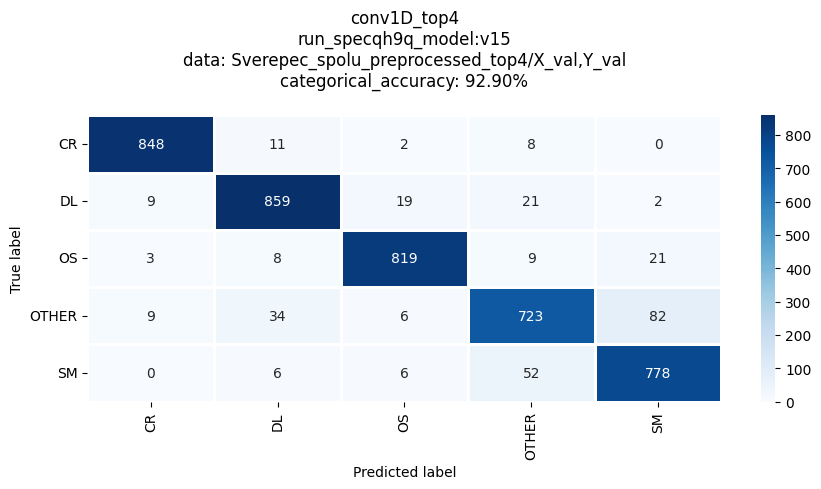

In [76]:
Y_pred = predict_model(model, X_val, Y_val, label_encoder=label_encoder)
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(Y_val, axis=1)), Y_pred)

eval_results = model.evaluate(X_val, Y_val, return_dict=True)
metric_name = 'categorical_accuracy'

fig, ax = plt.subplots(figsize=(9,5))
plot_cm(ax, cm, labels=label_encoder.classes_)
plt.title('%s\n%s\ndata: %s/X_val,Y_val\n%s: %.2f%%\n' % (
    cfg['model_name'],
    model_artifact.name,
    os.path.basename(cfg['data_dir']),
    metric_name,
    float(eval_results[metric_name]) * 100.0)
)
plt.tight_layout()
plt.savefig(os.path.join(cfg['data_dir'], 'cm-%s.pdf' % model_artifact.name), format='pdf')
plt.show()

In [77]:
tf.keras.utils.plot_model(
    model,
    to_file=os.path.join(cfg['data_dir'], '%s-arch.pdf' % model_artifact.name),
    expand_nested=True,
    show_shapes=True,
    show_layer_activations=True
)

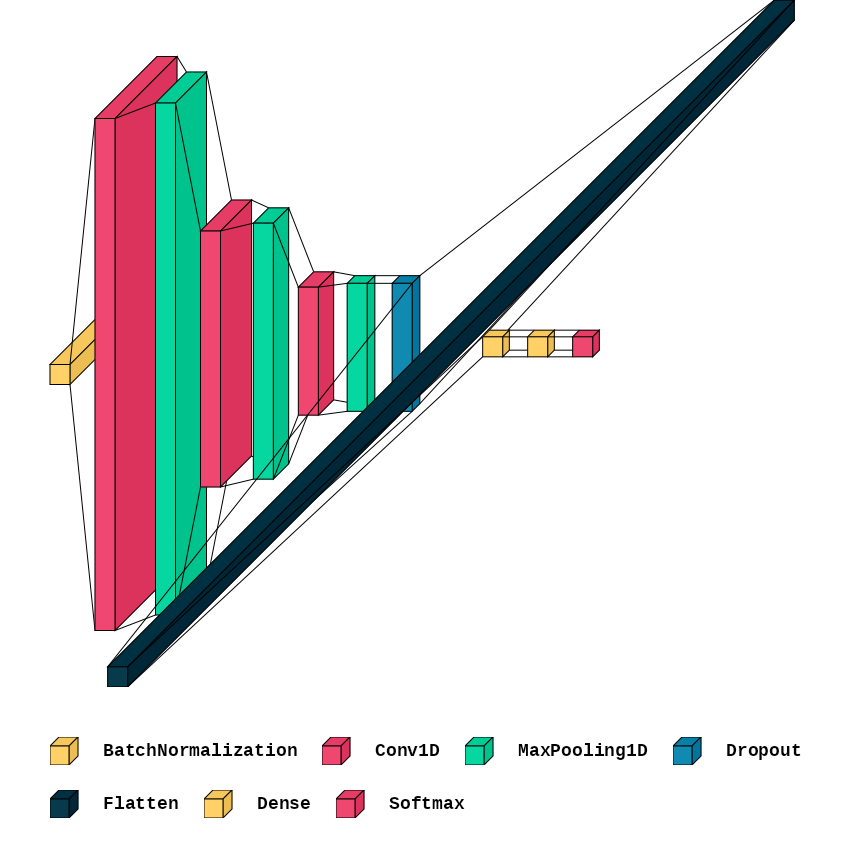

In [78]:
from PIL import ImageFont

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 18)

visualkeras.layered_view(
    model,
    to_file=os.path.join(cfg['data_dir'], '%s-arch.png' % model_artifact.name),
    legend=True,
    scale_xy=1,
    scale_z=1,
    one_dim_orientation='x',
    padding=50,
    spacing=25,
    font=font
)